# Cholera

In [1]:
import jax
import itertools
import numpy as onp
import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *

import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2023-07-28 20:14:53.904956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
covars = np.array(dataset.values)[:,2:]
gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**-3), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02

gamma = 20.8
epsilon = 19.1
rho = 7.1
delta = 0.02
m = 0.06
c = 0.7
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13
tau = 0.23 

theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs)

In [3]:
theta

Array([ 3.0349529, -2.8134108,  1.9600948,  2.9496884, -4.5      ,
        4.2364893, -4.98     ,  3.5383613,  2.3979158,  0.747    ,
        6.38     , -3.44     ,  4.23     ,  3.33     ,  4.55     ],      dtype=float32)

In [6]:
state = rinit(theta, 1, covars).squeeze()
keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(2)])
print(rprocess(np.array([state, state]), theta, keys, covars[0])) 
print(rprocesses(np.array([state, state]), np.array([theta, theta]), keys, covars[0]))

[[2141385.8      81928.88         0.        1771.1398   42170.74
    61494.773    97146.98  ]
 [1931574.5      93548.3          0.        2507.2148   87815.12
   138309.34    172144.3   ]]
[[2141385.8      81928.836        0.        1771.1398   42170.72
    61494.758    97146.96  ]
 [1931574.5      93548.3          0.        2507.2148   87815.12
   138309.34    172144.3   ]]


In [8]:
print(dmeasure(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars[0]) for i in range(20)]), theta))
print(dmeasures(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars[0]) for i in range(20)]), 
         np.vstack([theta+i for i in range(20)])))

[-10.79723  -10.79723  -10.79723  -10.79723  -10.797231 -10.797231
 -10.797231 -10.797231 -10.797232 -10.797232 -10.797232 -10.797232
 -10.797232 -10.797232 -10.797232 -10.797233 -10.797233 -10.797233
 -10.797234 -10.797234]
[-10.79723  -11.796368 -12.796251 -13.796236 -14.796234 -15.796234
 -16.796234 -17.796234 -18.796234 -19.796234 -20.796234 -21.796234
 -22.796236 -23.796236 -24.796234 -25.796234 -26.796234 -27.796236
 -28.796236 -29.796236]


In [5]:
def pfilter_monitor(theta, ys, covars=None, J=100, thresh=100):
    
    randint = onp.random.randint(0, 10000)
    particlesF = rinit(theta, J, covars=covars)
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    
    loglik = 0
    resamples = 0
    lls = []
    pps = []
    pfs = []
    wts = []
    for t in tqdm(range(len(ys))):
        keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(J)])
        # Get prediction particles 
        if covars is not None:
            particlesP = rprocess(particlesF, theta, keys, covars[t])# if t>0 else particlesF
        else:
            particlesP = rprocess(particlesF, theta, keys)
        
        # Resampling condition
        if np.exp(np.max(norm_weights))/np.exp(np.min(norm_weights)) > thresh:
            resamples += 1 #tracker
            # Systematic resampling
            counts = resample(norm_weights)
            particlesF = particlesP[counts]
            weights = norm_weights[counts] - jax.lax.stop_gradient(norm_weights[counts]) - np.log(J)
        else:
            particlesF = particlesP
            weights = norm_weights
            
        # Multiply weights by measurement model result
        keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(J)])
        weights += dmeasure(ys[t], particlesP, theta, keys=keys) #shape (Np,)
        
        # Obtain normalized weights
        norm_weights, loglik_t = normalize_weights(weights)
        pps.append(particlesP)
        pfs.append(particlesF)
        lls.append(loglik_t)
        wts.append(weights)
        
        # Sum up loglik
        loglik += loglik_t
        
    return -loglik, np.array(pps), np.array(pfs), np.array(lls), np.array(wts)

In [6]:
ll, pps, pfs, lls, wts = pfilter_monitor(theta, ys, covars, J=100, thresh=0)

100%|██████████| 600/600 [00:53<00:00, 11.20it/s]


In [18]:
%timeit pfilter(theta, ys, 1000, covars=covars, thresh=0)

322 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def test_pfilter(theta, ys, J, covars=covars, thresh=0):
    theta = theta + (np.abs(theta)/50)*onp.random.normal(theta.shape)
    return pfilter(theta, ys, J, covars=covars, thresh=thresh)

%timeit test_pfilter(theta, ys, 10000, covars=covars, thresh=0)

379 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
def pfilter_helper(t, inputs):
    particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key = inputs
    J = len(particlesF)
    
    key, *keys = jax.random.split(key, num=J+1)
    keys = np.array(keys)
        
    # Get prediction particles 
    if covars is not None:
        particlesP = rprocess(particlesF, theta, keys, covars[t])# if t>0 else particlesF
    else:
        particlesP = rprocess(particlesF, theta, keys, None)

    oddr = np.exp(np.max(norm_weights))/np.exp(np.min(norm_weights))
    # Systematic resampling
    counts, particlesF, weights = jax.lax.cond(oddr > thresh, 
                                               resampler, 
                                               no_resampler, 
                                               counts, particlesP, norm_weights)

    # Multiply weights by measurement model result
    weights += dmeasure(ys[t], particlesP, theta) #shape (Np,)

    # Obtain normalized weights
    norm_weights, loglik_t = normalize_weights(weights)

    # Sum up loglik
    loglik += loglik_t
    #jax.debug.print(loglik, loglik_t)
    return [particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key]
    
# test on linear gaussian toy model again
@partial(jit, static_argnums=2)
def pfilter(theta, ys, J, covars=None, thresh=100, key=None):
    if key is None:
        key = jax.random.PRNGKey(onp.random.choice(10000))
    
    particlesF = rinit(theta, J, covars=covars)
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key = jax.lax.fori_loop(
                lower=0, upper=len(ys), body_fun=pfilter_helper, 
                 init_val=[particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key])
    
    return -loglik

In [3]:
pfilter(theta, ys, 10000, covars=covars, thresh=0)

Array(4758.9756, dtype=float32)

In [8]:
thetas = theta + 0.000001*onp.random.normal(size=theta.shape)
perfilter(thetas, ys, 1000, np.abs(thetas)/100, covars=covars, a=0.9, thresh=0)

(Array(4597.0737, dtype=float32),
 Array([[ 3.4961054, -2.2232828,  2.9581356, ...,  5.2496543,  1.5818405,
          5.18843  ],
        [ 3.476117 , -2.1807625,  2.8734505, ...,  5.7166243,  2.3151662,
          5.3173485],
        [ 3.4719996, -2.4300053,  2.7493825, ...,  5.5669036,  2.2425556,
          5.3618917],
        ...,
        [ 3.6864758, -1.7376814,  2.5843296, ...,  5.0313344,  2.7217386,
          4.9633036],
        [ 3.6864758, -1.7376814,  2.5843296, ...,  5.0313344,  2.7217386,
          4.9633036],
        [ 3.6864758, -1.7376814,  2.5843296, ...,  5.0313344,  2.7217386,
          4.9633036]], dtype=float32))

In [3]:
n_trials = 1
J = 10000

sigmas = (np.abs(theta)/600)
theta_ests = theta + 12*sigmas*onp.random.normal(size=theta.shape)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})

"\ngd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,\n                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)\n\n\nnewt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, \n                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)\n\n"

In [83]:
newt_logliks, newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-1, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=5000, thresh=100, method='Newton', scale=False, ls=True)

  5%|▌         | 1/20 [00:39<12:38, 39.90s/it]

[ 3.063265   -2.8225324   1.8826017   2.9919522  -4.4901986   4.3314877
 -5.111591    3.6319897   2.445278    0.75793403  6.332764   -3.474576
  4.1869445   3.3010585   4.4734344 ] 0.9 828.0886


 10%|█         | 2/20 [01:19<11:58, 39.92s/it]

[ 2.9445364 -3.4356983  1.8826017  3.4675376 -4.605703   4.3314877
 -5.1140013  3.2952306  3.3575008  0.0023604  6.6455564 -5.262727
  3.6461535  2.9067578  4.431715 ] 0.9 819.62146


 15%|█▌        | 3/20 [02:01<11:34, 40.82s/it]

[ 2.452971  -5.0317574  1.8826017  3.9353578 -3.7814858  4.3314877
 -5.052938   2.8015876  4.220944  -1.21333    6.195161  -5.870097
  1.7164631  2.4506142  3.8246653] 0.0140625 811.40155


 20%|██        | 4/20 [02:41<10:48, 40.50s/it]

[ 2.4441059 -5.088895   1.8826017  3.9753728 -3.729661   4.3314877
 -5.047483   2.7969313  4.2357116 -1.2492899  6.20131   -5.925177
  1.7079536  2.418701   3.8311212] 0.0140625 811.55695


 25%|██▌       | 5/20 [03:21<10:04, 40.32s/it]

[ 2.428618  -5.0487704  1.8826017  3.8052237 -3.770293   4.3314877
 -5.0811515  2.785894   4.2472787 -1.2454139  6.1212387 -5.831265
  1.5951525  2.4593003  3.769481 ] 0.0140625 811.5574


 30%|███       | 6/20 [04:03<09:31, 40.83s/it]

[ 2.4156733 -5.094363   1.8826017  4.1538906 -3.718818   4.3314877
 -5.0834765  2.7699955  4.2588363 -1.2568228  6.1313977 -5.903932
  1.5194738  2.5168428  3.6749263] 0.0140625 811.796


 35%|███▌      | 7/20 [04:43<08:47, 40.56s/it]

[ 2.4134567 -5.080036   1.8826017  3.6567767 -3.7224033  4.3314877
 -5.2316623  2.7896113  4.2711844 -1.2528738  6.1203666 -6.033438
  1.4286133  2.5747666  3.652879 ] 0.0140625 812.1305


 40%|████      | 8/20 [05:23<08:04, 40.38s/it]

[ 2.407973  -5.1031594  1.8826017  3.6130645 -3.6973584  4.3314877
 -5.2310767  2.7899566  4.2849164 -1.2537779  6.094337  -6.0109167
  1.443537   2.5193493  3.664864 ] 0.0140625 812.08


 45%|████▌     | 9/20 [06:05<07:29, 40.86s/it]

[ 2.4077628 -5.193826   1.8826017  3.9187825 -3.6118855  4.3314877
 -5.2115126  2.7902336  4.3002033 -1.2870725  6.0974417 -5.970244
  1.4148453  2.533756   3.6616633] 0.0140625 811.65015


 50%|█████     | 10/20 [06:45<06:46, 40.61s/it]

[ 2.4074788 -5.2245727  1.8826017  4.0043197 -3.5734692  4.3314877
 -5.2097945  2.7905118  4.313405  -1.2848003  6.1098475 -6.050165
  1.4287982  2.4990835  3.6733413] 0.0140625 811.54395


 55%|█████▌    | 11/20 [07:27<06:09, 41.09s/it]

[ 2.3978488 -5.2299595  1.8826017  4.2482395 -3.582496   4.3314877
 -5.190827   2.7839894  4.3270516 -1.2878208  6.0761943 -6.0262256
  1.3721449  2.5170674  3.6428623] 0.0140625 811.8397


 60%|██████    | 12/20 [08:07<05:26, 40.77s/it]

[ 2.3833888 -5.332856   1.8826017  4.414183  -3.4975119  4.3314877
 -5.1785707  2.7706912  4.3418236 -1.3133947  6.0368257 -5.9774704
  1.3353183  2.5120108  3.6274347] 0.0140625 812.07446


 65%|██████▌   | 13/20 [08:47<04:43, 40.52s/it]

[ 2.3855705 -5.3393493  1.8826017  4.8015575 -3.4922411  4.3314877
 -5.1395645  2.7713838  4.35487   -1.2918701  6.0630164 -6.0711055
  1.2727883  2.566095   3.5739455] 0.0140625 812.81226


 70%|███████   | 14/20 [09:29<04:05, 40.93s/it]

[ 2.3657126 -5.411189   1.8826017  4.7961607 -3.4064953  4.3314877
 -5.1337996  2.7928243  4.3682737 -1.3882803  6.0975165 -6.114931
  1.3025967  2.5092852  3.612704 ] 0.0140625 812.9811


 75%|███████▌  | 15/20 [10:09<03:23, 40.62s/it]

[ 2.3536282 -5.427166   1.8826017  4.7985916 -3.401632   4.3314877
 -5.133697   2.7869825  4.3821015 -1.4048871  6.0643134 -6.0983214
  1.2529272  2.5181706  3.580218 ] 0.0140625 812.8837


 80%|████████  | 16/20 [10:49<02:41, 40.44s/it]

[ 2.34853    -5.345802    1.8826017   4.803126   -3.5979605   4.3314877
 -5.061665    2.7990093   4.4036083  -0.8860973   6.0232835  -6.1447787
  0.54181075  3.4555502   2.811403  ] 0.0140625 815.26917


 85%|████████▌ | 17/20 [11:31<02:02, 40.88s/it]

[ 2.3287182 -5.3439794  1.8826017  4.8041453 -3.5929804  4.3314877
 -5.061263   2.808608   4.417178  -0.8897576  5.976576  -6.119136
  0.5162161  3.4394534  2.7971728] 0.0140625 815.7182


 90%|█████████ | 18/20 [12:11<01:21, 40.62s/it]

[ 2.3113036  -5.3757167   1.8826017   4.8069715  -3.569204    4.3314877
 -5.0568905   2.794862    4.4299893  -0.9327046   5.951241   -6.1651206
  0.49193844  3.410882    2.7871752 ] 0.0140625 815.5328


 95%|█████████▌| 19/20 [12:51<00:40, 40.44s/it]

[ 2.2833567  -5.3453565   1.8826017   4.8107414  -3.5789864   4.3314877
 -5.0607505   2.818402    4.4430666  -0.7821184   5.7715254  -6.0592184
  0.49240524  3.382781    2.7504582 ] 0.0140625 816.57684


100%|██████████| 20/20 [13:33<00:00, 40.66s/it]

[ 2.274463  -5.4174643  1.8826017  4.8116164 -3.5212681  4.3314877
 -5.0590706  2.8189037  4.4587035 -0.8159413  5.781567  -6.053656
  0.4875747  3.3642683  2.746743 ] 0.0140625 816.471


In [78]:
weighted_newt_logliks, weighted_newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=5000, thresh=100, method='WeightedNewton', scale=False, ls=True)

  5%|▌         | 1/20 [00:02<00:44,  2.33s/it]

[ 3.063265   -2.8225324   1.8826017   2.9919522  -4.4901986   4.3314877
 -5.111591    3.6319897   2.445278    0.75793403  6.332764   -3.474576
  4.1869445   3.3010585   4.4734344 ] 0.9 828.0261


 10%|█         | 2/20 [00:04<00:41,  2.33s/it]

[ 3.309584  -4.6651897  1.8826017  3.1009266 -3.1976612  4.3314877
 -5.9552293  3.6422508  3.3709705  2.23901    5.3269563 -1.3128626
  3.0911436  4.0043206  3.743666 ] 0.9 821.60815


 15%|█▌        | 3/20 [00:06<00:39,  2.32s/it]

[ 3.1816216 -6.459339   1.8826017  3.484057  -1.6432235  4.3314877
 -6.381004   3.7192488  3.8359501  2.3597777  5.9035506 -5.119028
  2.8278337  3.9361842  3.599668 ] 0.9 813.1454


 20%|██        | 4/20 [00:09<00:37,  2.31s/it]

[ 2.950105   -6.5103974   1.8826017   1.8844856  -2.478362    4.3314877
 -7.685606    3.2583835   4.5435696   2.085349    4.1645846   0.8045769
  0.13961911  4.935178    2.5926132 ] 0.0140625 809.4787


 25%|██▌       | 5/20 [00:11<00:34,  2.32s/it]

[ 2.88455    -6.6115336   1.8826017   2.2909954  -2.24263     4.3314877
 -8.887669    3.214687    4.5520177   1.6013105   4.4246993  -0.46841908
  0.24305123  4.799272    2.4434202 ] 0.0140625 813.07587


 30%|███       | 6/20 [00:13<00:32,  2.32s/it]

[ 2.8138204  -6.737207    1.8826017   2.2777476  -2.2191982   4.3314877
 -8.805956    3.114826    4.563875    1.6483642   4.219495   -0.29364014
 -0.15815148  4.9952707   2.1052697 ] 0.0140625 812.7558


 35%|███▌      | 7/20 [00:16<00:30,  2.32s/it]

[ 2.8042028  -6.778081    1.8826017   2.261229   -2.1918628   4.3314877
 -8.805324    3.120942    4.578437    1.6384588   4.2121396  -0.2778461
 -0.18124762  4.9965315   2.098449  ] 0.0140625 813.0727


 40%|████      | 8/20 [00:18<00:27,  2.32s/it]

[ 2.7967432  -6.793157    1.8826017   2.2398674  -2.184941    4.3314877
 -8.804942    3.1208403   4.5919075   1.6436335   4.1885314  -0.28046715
 -0.218105    5.0024543   2.0815995 ] 0.0140625 813.2149


 45%|████▌     | 9/20 [00:20<00:25,  2.32s/it]

[ 2.788399  -6.805344   1.8826017  2.2162983 -2.1850257  4.3314877
 -9.253884   3.1135695  4.6054025  1.6190966  4.1284313 -0.1489737
 -0.3426639  5.041866   2.0270298] 0.0140625 812.9498


 50%|█████     | 10/20 [00:23<00:23,  2.32s/it]

[ 2.7845757  -6.811968    1.8826017   2.1974168  -2.1853771   4.3314877
 -9.249796    3.111839    4.61857     1.6242638   4.1025805  -0.09811519
 -0.42102712  5.0748215   1.9933425 ] 0.0140625 812.76404


 55%|█████▌    | 11/20 [00:25<00:20,  2.32s/it]

[ 2.7749567  -6.8550763   1.8826017   2.195716   -2.1622565   4.3314877
 -9.247457    3.1135013   4.6330376   1.5844909   4.1190104  -0.13886039
 -0.4038926   5.0428333   2.018719  ] 0.0140625 812.8215


 60%|██████    | 12/20 [00:27<00:18,  2.32s/it]

[ 2.765233   -6.873525    1.8826017   2.122189   -2.1781085   4.3314877
 -9.244301    3.1174743   4.648525    1.5650189   4.1447473  -0.2026828
 -0.35959357  4.9953456   2.0630445 ] 0.0140625 812.14667


 65%|██████▌   | 13/20 [00:30<00:16,  2.32s/it]

[ 2.7610757  -6.9063187   1.8826017   2.1579878  -2.134532    4.3314877
 -9.242399    3.1227472   4.662103    1.5401933   4.126684   -0.20060426
 -0.36596498  4.982815    2.0688539 ] 0.0140625 812.6111


 70%|███████   | 14/20 [00:32<00:13,  2.32s/it]

[ 2.746075   -6.877979    1.8826017   1.9955685  -2.1780624   4.3314877
 -9.234542    3.1336634   4.6764812   1.5841161   4.0913     -0.12064246
 -0.47046375  5.0442905   1.9768071 ] 0.0140625 812.29846


 75%|███████▌  | 15/20 [00:34<00:11,  2.31s/it]

[ 2.749125   -6.842248    1.8826017   1.9974328  -2.158034    4.3314877
 -8.757258    3.14113     4.6886506   1.526399    4.0823197  -0.06590648
 -0.48308674  5.0095224   2.013572  ] 0.0140625 812.9306


 80%|████████  | 16/20 [00:37<00:09,  2.31s/it]

[ 2.7341132  -6.885373    1.8826017   1.997569   -2.1345577   4.3314877
 -8.794573    3.1366065   4.7015576   1.5675387   3.9778748   0.14667474
 -0.6603923   5.102425    1.9032509 ] 0.0140625 812.88324


 85%|████████▌ | 17/20 [00:39<00:06,  2.32s/it]

[ 2.7185705  -6.933804    1.8826017   1.990436   -2.1007643   4.3314877
 -8.794281    3.1397924   4.714991    1.5716207   3.9141045   0.27087313
 -0.8017837   5.1580534   1.8476422 ] 0.0140625 813.3164


 90%|█████████ | 18/20 [00:41<00:04,  2.31s/it]

[ 2.712465   -6.9556713   1.8826017   2.0097644  -2.0853624   4.3314877
 -8.796698    3.1350417   4.728382    1.5571707   3.8821497   0.31649005
 -0.8406164   5.1552124   1.8388087 ] 0.0140625 813.3336


 95%|█████████▌| 19/20 [00:44<00:02,  2.31s/it]

[ 2.7098296  -6.991035    1.8826017   2.0194867  -2.0405748   4.3314877
 -8.800038    3.1327248   4.7412863   1.5100297   3.9248266   0.14025965
 -0.8070784   5.0959044   1.894967  ] 0.0140625 813.9434


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]

[ 2.703009   -7.024309    1.8826017   2.015661   -2.0118551   4.3314877
 -8.798809    3.1399827   4.7557917   1.4912095   3.9177723   0.13056353
 -0.81729716  5.0848327   1.9100047 ] 0.0140625 812.78613


In [ ]:
# make direct call to rprocess, dmeasure, check given close to deterministic noise
#simulate(rprocess(dacca)), find parameters to get splines to return constant (all constants equal)

#make plot of runtime of backward pass vs number of particles and number of timesteps

#try adaptive swapping between IF2 and AD
#Benchmark local search when MLE found, for swapping to AD to be worth it

In [ ]:
bfgs_logliks, bfgs_ests = train(theta_ests, ys[:100], covars, beta=0.9*10, eta=0.2, c=0.01, max_ls_itn=30, 
                            verbose=True, itns=100, J=J, thresh=0, method='BFGS', scale=True, ls=False)

In [68]:
mif_logliks, mif_params = mif(theta_ests, ys[:100], sigmas=2*sigmas, 
                              sigmas_init = 6*sigmas, covars=covars,
                              M=100, J=J, a=0.99, monitor=True, thresh=0)

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


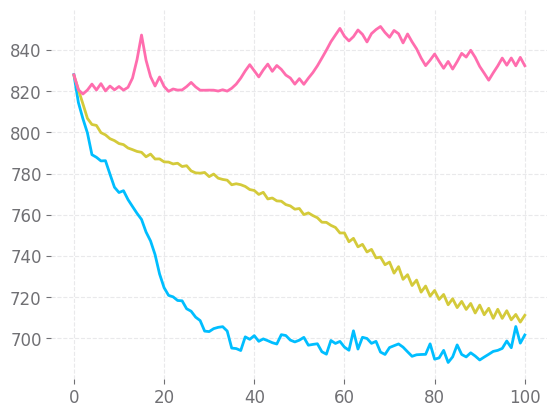

In [72]:
plt.plot(mif_logliks)
plt.plot(gd_logliks)
plt.plot(bfgs_logliks)

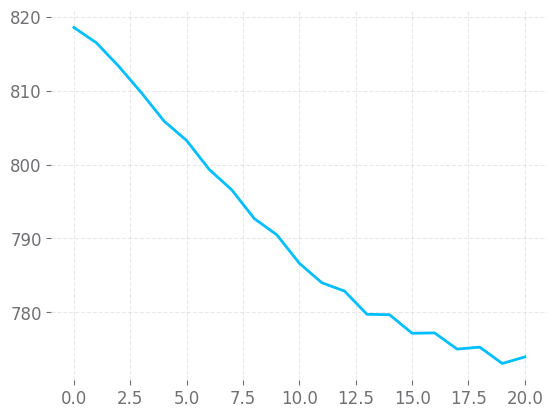

In [51]:
plt.plot(gd_logliks)

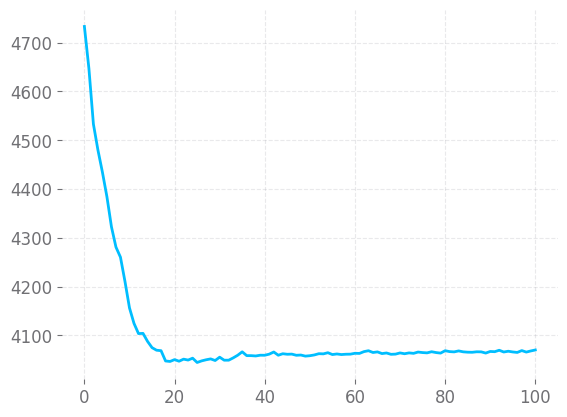

In [13]:
plt.plot(mif_logliks)

In [56]:
gd_logliks, gd_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=0.2, 
                            verbose=False, itns=100, J=J, thresh=100, method='SGD', ls=False, scale=True)

100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


In [ ]:
newtif_logliks, newtif_params = newtif(theta_ests, ys, sigmas=sigmas, 
                                       sigmas_init = sigmas, covars=covars, 
                                       M=100, J=10000, Jh=500, a=0.95, beta=0.9, tau=5, 
                                       monitor=True, verbose=True, thresh=0)

In [10]:
get_thetas(mif_params[-1].mean(0))

(Array(42.156467, dtype=float32),
 Array(0.07089243, dtype=float32),
 Array(9.570239, dtype=float32),
 Array(34.269917, dtype=float32),
 Array(0.12983567, dtype=float32),
 Array(0.19239144, dtype=float32),
 Array(-0.00586496, dtype=float32),
 Array(4.7417436, dtype=float32),
 Array(1.2022542, dtype=float32),
 Array([ 0.97967553,  7.78592   , -4.4916477 ,  5.4493256 ,  3.7110734 ,
         4.8851376 ], dtype=float32),
 3,
 0.02)

In [141]:
pfilter(newtif_params[-1].mean(0), ys, J, covars, thresh=0)
-21107
-3784
-4421 

Array(4421.316, dtype=float32)

In [130]:
transform_thetas

1.8421242 ,  8.268211  , -0.80884415,  5.4024425 ,  4.682495  , 6.466499

<function pomps.transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs)>

In [134]:
pd.DataFrame([newt_logliks, weighted_newt_logliks, bfgs_logliks, gd_logliks, mif_logliks, newtif_logliks], 
             index=['Newton', 'Weighted Newton', 'Quasi-Newton', 'Gradient Descent', 'IF2', 'Newton IF2']
            ).T.to_csv('data/dacca/fit1.csv')

In [278]:
def rproc(state, theta, key, covar):
    S, I, Y, deaths, pts = state[0], state[1], state[2], state[3], state[4:]
    trend, dpopdt, pop, seas = covar[0], covar[1], covar[2], covar[3:]
    gamma, deltaI, rho, eps, omega, clin, beta_trend, sd_beta, tau, bs, nrstage, delta = get_thetas(theta)
    dt = 1/240
    deaths = 0
    nrstage = 3
    
    neps = eps*nrstage
    rdeaths = np.zeros(nrstage)
    passages = np.zeros(nrstage+1)
    
        
    for i in range(20):
        subkey, key = jax.random.split(key)
        dw = jax.random.normal(subkey)*onp.sqrt(dt)
        beta = np.exp(beta_trend*trend + np.dot(bs, seas))
        
        effI = I/pop;
        births = dpopdt + delta*pop # births
        passages = passages.at[0].set(gamma*I) #recovery
        ideaths = delta*I #natural i deaths
        disease = deltaI*I #disease death
        ydeaths = delta*Y #natural rs deaths
        wanings = rho*Y #loss of immunity
        
        for j in range(nrstage):
            rdeaths = rdeaths.at[j].set(pts[j]*delta) #natural R deaths
            passages = passages.at[j+1].set(pts[j]*neps) # passage to the next immunity class
            
        infections = (omega+(beta+sd_beta*dw/dt)*effI)*S # infection
        sdeaths = delta*S # natural S deaths
        
        S += (births - infections - sdeaths + passages[nrstage] + wanings)*dt
        I += (clin*infections - disease - ideaths - passages[0])*dt
        Y += ((1-clin)*infections - ydeaths - wanings)*dt
        for j in range(nrstage):
            pts = pts.at[j].add((passages[j] - passages[j+1] - rdeaths[j])*dt)
        deaths += disease*dt # cumulative deaths due to disease

        
    return np.hstack([np.array([S, I, Y, deaths]), pts])

rprocess = jax.jit(jax.vmap(rproc, (0, None, 0,None)))

In [3]:
#params = mif_params[-1].mean(0)
params = theta
traj = [rinit(params, 10, covars)]
for i in tqdm(range(len(ys))):
    traj.append(rprocess(traj[-1], params, 
                         np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(10)]), covars[i]))

100%|██████████| 600/600 [00:05<00:00, 104.09it/s]


In [12]:
rinit(params, 1, covars)

Array([[1504242.9      ,  915626.06     ,       0.       ,
              0.       ,    2041.9916   ,    2354.467    ,
              0.2809858]], dtype=float32)

In [13]:
rprocess(traj[0], params, 
            np.array([jax.random.PRNGKey(i+1) for i in range(10)]), covars[0])

Array([[2209907.8   ,   43203.25  ,       0.    ,    1679.4155,
          38682.71  ,   59562.8   ,   72862.25  ],
       [2207479.    ,   40599.195 ,       0.    ,    2363.5247,
          35215.695 ,   61794.133 ,   78447.516 ],
       [2206383.    ,   68591.23  ,       0.    ,    1863.158 ,
          31769.156 ,   47955.934 ,   69335.67  ],
       [2230956.    ,   62026.75  ,       0.    ,    1379.1213,
          33723.9   ,   43682.207 ,   54130.387 ],
       [2224260.2   ,   40419.    ,       0.    ,    1995.7211,
          37207.934 ,   52461.676 ,   69553.61  ],
       [2141872.5   ,   85573.22  ,       0.    ,    2173.0605,
          50045.965 ,   63680.797 ,   82553.64  ],
       [2156566.5   ,   62309.145 ,       0.    ,    2382.3223,
          49505.82  ,   65413.875 ,   89721.17  ],
       [2211687.    ,   50096.5   ,       0.    ,    2420.2144,
          27971.979 ,   49739.734 ,   83983.67  ],
       [1950424.6   ,  110655.03  ,       0.    ,    2672.76  ,
          83996.

In [367]:
onp.array(traj)[:,:,3].T

array([[   0.      , 2316.7136  , 1333.8518  , ...,   62.546658,
         262.12775 ,  413.5125  ],
       [   0.      , 2198.1426  , 1289.8505  , ...,   44.100216,
         236.93623 ,  486.21036 ],
       [   0.      , 2213.7585  , 1320.536   , ...,   71.18263 ,
         324.24167 ,  480.44202 ],
       ...,
       [   0.      , 2276.5525  , 1323.7949  , ...,   73.362854,
         296.30576 ,  450.15884 ],
       [   0.      , 2219.7961  , 1232.4832  , ...,   49.37278 ,
         231.95905 ,  445.79034 ],
       [   0.      , 2285.5107  , 1311.6774  , ...,  105.49376 ,
         438.52002 ,  619.7222  ]], dtype=float32)

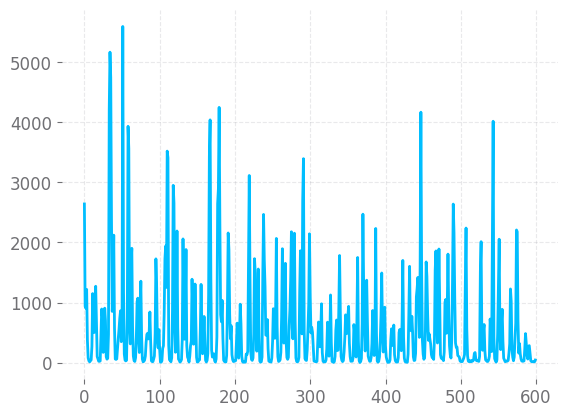

In [318]:
plt.plot(ys)

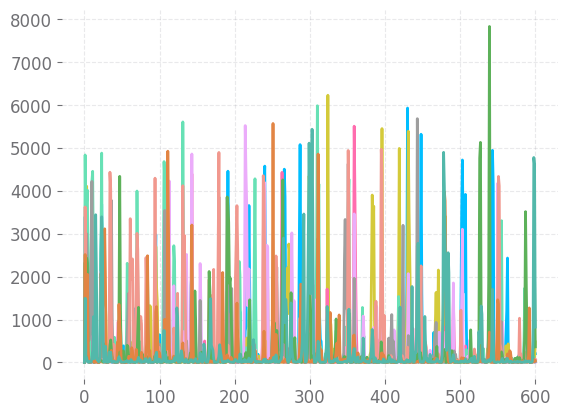

In [6]:
plt.plot(onp.array([onp.array(traj)[:,i,3] for i in range(10)]).T)
plt.ticklabel_format(style='plain') 
plt.show()

In [13]:
get_thetas(params)

(Array(20.799997, dtype=float32),
 Array(0.06, dtype=float32),
 Array(7.1000004, dtype=float32),
 Array(19.1, dtype=float32),
 Array(0.011109, dtype=float32),
 Array(0.19714956, dtype=float32),
 Array(-0.00498, dtype=float32),
 Array(6.26, dtype=float32),
 Array(1.1500001, dtype=float32),
 Array([ 0.747,  6.38 , -3.44 ,  4.23 ,  3.33 ,  4.55 ], dtype=float32),
 3,
 0.02)

In [335]:
dmeasure(ys[1], traj[1], params)

Array([-11.459982 , -11.574373 , -11.592973 , -11.676937 , -11.535193 ,
       -11.512705 , -11.559515 , -11.405407 , -11.6376295, -11.470377 ],      dtype=float32)

In [336]:
traj[1].shape

(10, 7)

In [348]:
ys[2]

Array(905, dtype=int32)

In [349]:
traj[1][3]

Array([1044925.3   ,  560094.8   ,  608348.56  ,    3310.9465,
         61666.29  ,   70525.78  ,   77027.37  ], dtype=float32)

In [354]:
jax.scipy.stats.norm.logpdf(ys[2], loc=traj[1][3], scale=6*traj[1][3])

Array([-16.584019 , -15.960403 , -16.043049 , -10.823021 , -13.7536745,
       -13.887966 , -13.976178 ], dtype=float32)

In [ ]:
norm_dmeas <- Csnippet("
    double v, tol = 1.0e-18;
    v = deaths*tau;
    if ((count>0.0) || (!(R_FINITE(v)))) {
    lik = tol;
    } else {
    lik = dnorm(cholera_deaths,deaths,deaths*tau,0)+tol;
    }
    if (give_log) lik = log(lik);
  ")

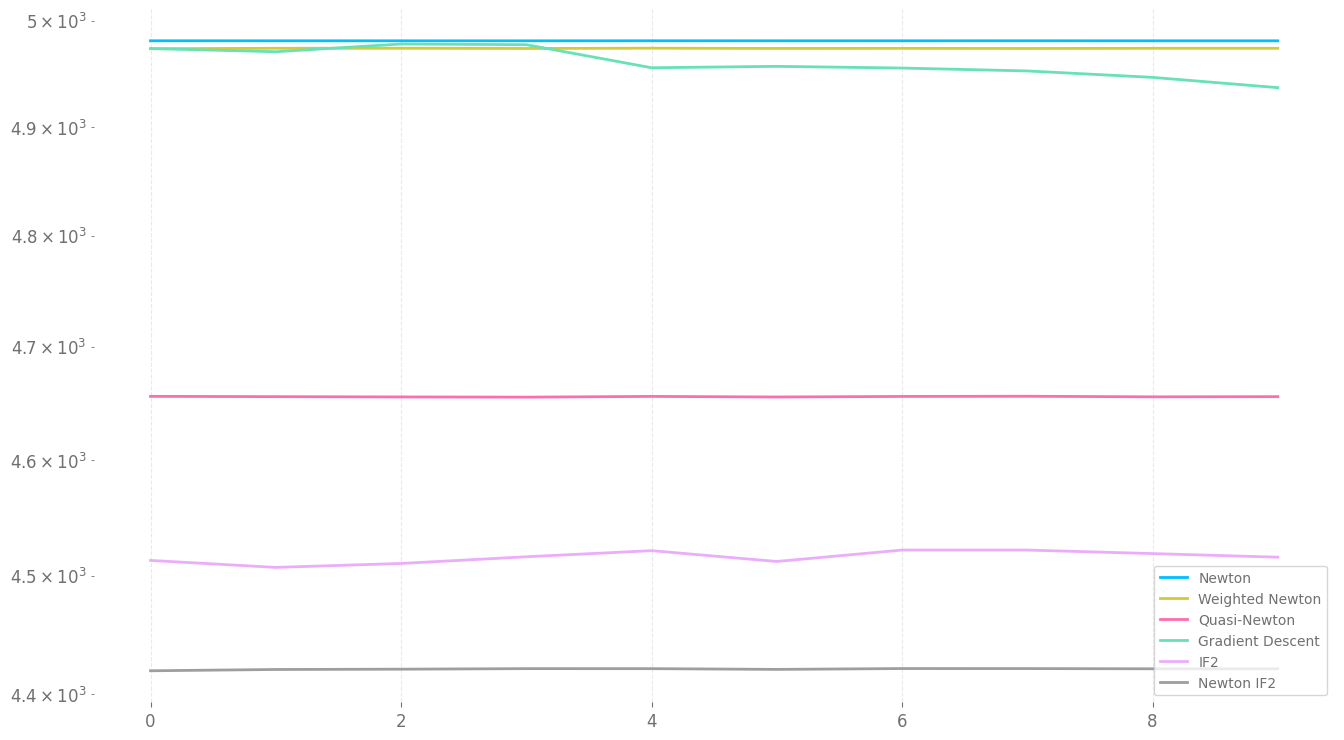

In [165]:
plt.figure(figsize=(16,9))
fro = 90
to = 100
plt.plot(newt_logliks[fro:to], label='Newton')
plt.plot(weighted_newt_logliks[fro:to], label='Weighted Newton')
plt.plot(bfgs_logliks[fro:to], label='Quasi-Newton')
plt.plot(gd_logliks[fro:to], label='Gradient Descent')
plt.plot(mif_logliks[fro:to], label='IF2')
plt.plot(newtif_logliks[fro:to], label='Newton IF2')
plt.legend()
plt.yscale('log')
#plt.xscale('log')
#plt.yticks(np.logspace(3,5,10)*3, np.logspace(3,5,10)*3)
plt.show()

In [83]:
@partial(jit, static_argnums=2)
def jpgrad(thetas, ys, J, sigmas, covars, a, thresh):
    return jax.grad(perfilter, has_aux=True)(
        thetas, ys, J, sigmas, covars=covars, a=a,thresh=thresh)

def newtif(theta, ys, sigmas, sigmas_init, covars=None, M=10,
           a=0.9, beta=0.9, tau=10, J=5000, Jh=1000, thresh=100, monitor=False, verbose=False):
    
    logliks = []
    params = []
    
    # Pertubation on first iteration
    thetas = theta + sigmas_init*onp.random.normal(size=(J, theta.shape[-1]))
    params.append(thetas)
    
    if monitor:
        loglik = np.mean(np.array([pfilter(thetas.mean(0), ys, J, covars=covars, thresh=thresh) for i in range(MONITORS)]))
        logliks.append(loglik)
        
    
    # outer iterative loop 
    for m in tqdm(range(M)):
        # annealing pertubations
        sigmas *= a
        #thetas += sigmas*onp.random.normal(size=thetas.shape)
        if m == 0:
            pass
        else:
            
            # Newton update
            grad = jax.grad(perfilter, has_aux=True)(theta, 
                ys, sigmas=sigmas, covars=covars, a=a, J=J, thresh=thresh)[0]
            hess = jax.hessian(perfilter, has_aux=True)(theta, 
                ys, sigmas=sigmas, covars=covars, a=a, J=Jh, thresh=thresh)[0]
            direction = -np.linalg.pinv(hess) @ grad
            eta = line_search(partial(pfilter, ys=ys, covars=covars, J=J, thresh=thresh), 
                              loglik, thetas.mean(0), grad, direction, k=m+1, eta=beta, tau=tau)
            thetas += eta*direction
            #print(eta*direction, thetas.mean(0))
            '''
            grad = jpgrad(thetas, 
                ys, J, sigmas, covars=covars, a=a,thresh=thresh)[0]
            direction = -np.nan_to_num(grad, 0)
            eta = np.sqrt(len(ys)*sigmas**2)
            thetas += eta*direction
            #print(eta, eta*np.mean(direction, axis=0), thetas.mean(0))
            '''
        '''
        loglik_thetas_ext, grad = jax.value_and_grad(
                                    perfilter, 
                                    has_aux=True)(
                            thetas, ys, sigmas=sigmas, 
                            a=a, J=J, thresh=thresh)
        loglik_ext, thetas = loglik_thetas_ext
        '''
        loglik_ext, thetas = perfilter(thetas, ys, J, sigmas, covars=covars, a=a, thresh=thresh)
        theta = thetas.mean(0)
        
        params.append(thetas)
        
        #code for monitoring logliks and verbose output
        if monitor:
            loglik = np.mean(np.array([pfilter(thetas.mean(0), ys, J, covars=covars, thresh=thresh) 
                                       for i in range(MONITORS)]))
            logliks.append(loglik)
                  
            if verbose:
                if m > 0:
                    print(loglik, eta)
                else:
                    print(loglik)
                print(thetas.mean(0))
        
    return np.array(logliks), np.array(params)

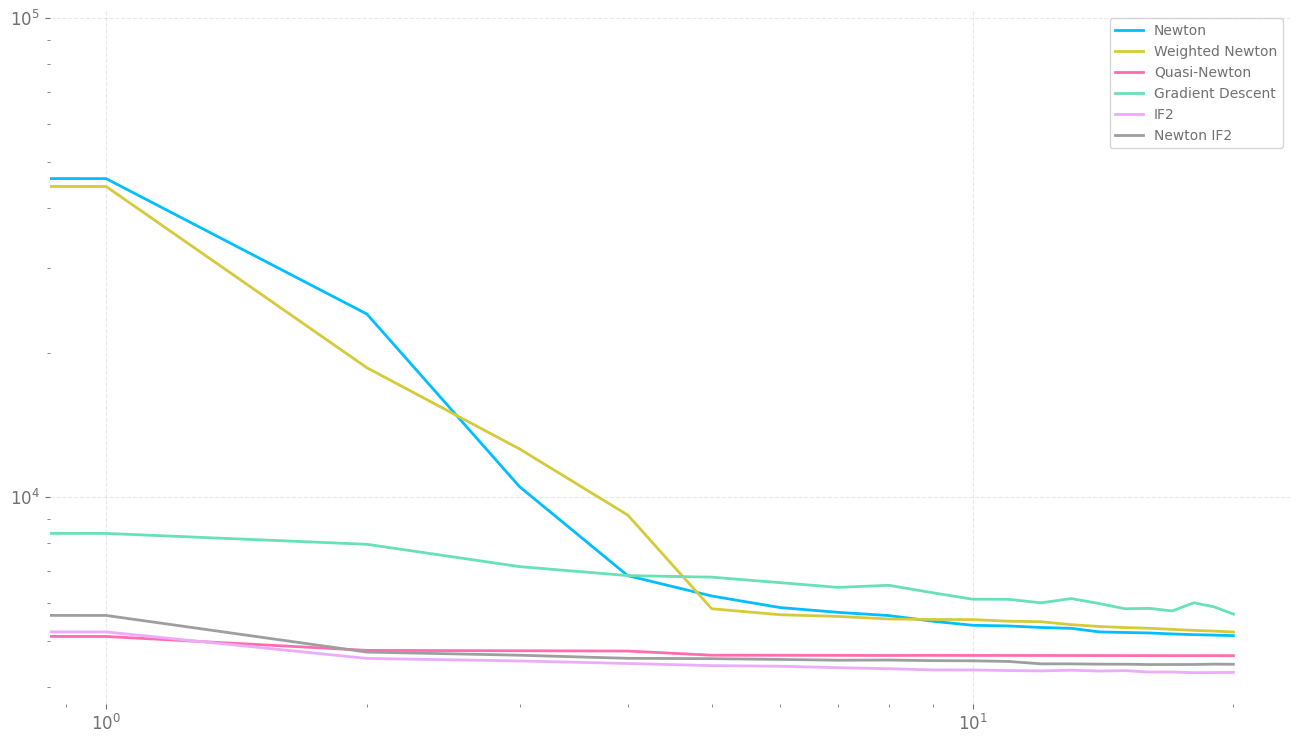

In [98]:
plt.figure(figsize=(16,9))
fro = 0
plt.plot(newt_logliks[fro:], label='Newton')
plt.plot(weighted_newt_logliks[fro:], label='Weighted Newton')
plt.plot(bfgs_logliks[fro:], label='Quasi-Newton')
plt.plot(gd_logliks[fro:], label='Gradient Descent')
plt.plot(mif_logliks[fro:], label='IF2')
plt.plot(newtif_logliks[fro:], label='Newton IF2')
plt.legend()
plt.yscale('log')
plt.xscale('log')
#plt.yticks(np.logspace(3,5,10)*3, np.logspace(3,5,10)*3)
plt.show()

In [ ]:
newtif_logliks, newtif_params = newtif(theta_ests, ys, sigmas=np.array([0.001,0.0005,0.0005]), 
                                       sigmas_init = np.array([0.5,0.25,0.25]),
                                       M=10, J=100, a=0.8, beta=0.9, tau=10, monitor=True, thresh=0)
mif_logliks, mif_params = mif(theta_ests, ys, sigmas = np.array([0.001,0.0005,0.0005]), 
                              sigmas_init = np.array([0.5,0.25,0.25]),
                              M=10, J=100, a=0.8, monitor=True, thresh=0)
gd_logliks, gd_ests = train(theta_ests, ys, itns=10, J=100, thresh=0, newt=False)
newt_logliks, newt_ests = train(theta_ests, ys, itns=10, J=100, thresh=0, newt=True)

In [ ]:
plt.plot(np.array(gd_loglik_trials).squeeze())